In [1]:
import matplotlib.pylab as plt
import numpy as np
import MDAnalysis as mdanal
%matplotlib inline

In [2]:
def getCoordinates(pdbFileName, trjFileName):
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False);
    frames = [];
    Ca = u.select_atoms('name CA');
    for ts in u.trajectory:
        frames.append(Ca.positions.T);
    return np.array(frames);

In [3]:
import os
indir = '/Volumes/LaCie/DESRES-Trajectory-bpti-protein/bpti-protein/'
topfile = '/Users/fxp/BPTI-Analysis/bpti-protein.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('.dcd'):
        traj_list.append(os.path.join(indir,filename))

In [4]:
plt.style.use('ggplot')

In [5]:
coords = []
for trj in traj_list:
    coords.append(getCoordinates(topfile, trj))
coords = np.vstack(coords)

In [6]:
coords = coords[::10, :, :];

In [7]:
from anca import IterativeMeansAlign
iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(coords, 0.001, 5);

No handlers could be found for logger "main.IterativeMeansAlign"


In [8]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), 3*58)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 412497), (412497,3*58)).T; 
caDevsMDall = coordsAll - tmpAll;
print caDevsMDall.shape;

(174, 412497)


In [9]:
import scipy.stats
 
def getSmoothingWeights(dt, windowsize, halflife):
    tau = (halflife/dt)/ np.log(2) # half-life = 5000ns and time between 2 consecutive time frame = 25ns
    alpha = 1 - np.exp(-1/tau)
    s = 0;
    wt = np.zeros((windowsize,1));
    for i in range (0,windowsize):
        wt[i] = (alpha * np.exp(-(windowsize-i)/tau))/0.96499303
        s = s + wt[i];
    return wt;
 
def getInstantaenousKurtosis(caDevsMDall, dt, windowsize, halflife, perRes=True, smooth=False):
    kresVals = np.zeros((caDevsMDall.shape[0], caDevsMDall.shape[1]));
    kvals = np.zeros((caDevsMDall.shape[1],1));
   
    for i in range(0, caDevsMDall.shape[1]):
        cc = caDevsMDall[:, i:i+windowsize];
        kresVals[:, i] = scipy.stats.kurtosis(cc, axis=1, fisher=False);
        kvals[i] = scipy.stats.kurtosis(cc, axis=1, fisher=False).mean();
        
    c = np.zeros(caDevsMDall.shape[1]-windowsize);
    if not perRes and smooth:
        val = np.zeros((windowsize,1));
        wt = getSmoothingWeights(dt, windowsize, halflife);
        for i in range (0, caDevsMDall.shape[1]-windowsize):
            a = wt[0:windowsize];
            a = a.reshape(windowsize);
            b = kvals[i + windowsize:i:-1];
            b = b.reshape(windowsize);
            c[i] = np.dot(a,b);
        return c, kvals;
    elif perRes:
        return kresVals, kvals;
    else:
        return kvals;

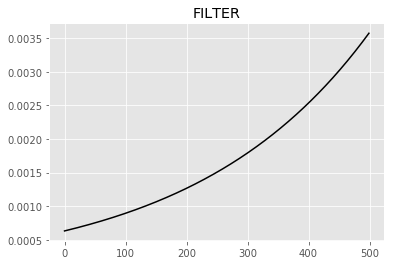

In [10]:
wt = getSmoothingWeights(dt=25, windowsize=500,halflife=5000)
plt.title('FILTER')    
plt.plot(wt, 'k-');
plt.show();

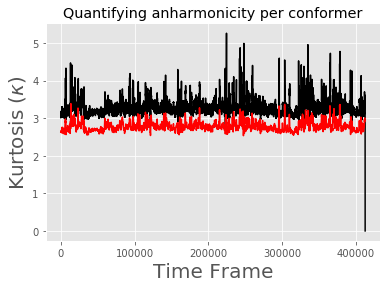

In [11]:
[c, kvals] = getInstantaenousKurtosis(caDevsMDall=caDevsMDall, dt=25, windowsize=500, halflife=5000, perRes=False, smooth=True)

plt.title('Quantifying anharmonicity per conformer')    
plt.plot(kvals, 'k-'); 
plt.plot(c, 'r-');
plt.xlabel('Time Frame', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.show();

In [12]:
import numpy as np
import pandas as pd
rd = pd.DataFrame(kvals)
median = pd.DataFrame({'median':rd.median()})

threshold = 1.5
val = median + threshold
print val

     median
0  4.742007


In [13]:
hkurt = np.where(kvals>4.742007)[0]
np.savetxt('high-kurtosis.txt',hkurt,delimiter=',')

In [14]:
# function to get consecutive numbers as a separate list

def events(vals, step = 1):
    
    run = []
    result = [run]
    expect = None
    for v in vals:
        if(v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    
    return result

In [15]:
# array has list of events with window size = 500
array = events(hkurt)
array = np.asarray(array)

In [ ]:
u = mdanal.Universe(topfile, traj_list)
allatoms = u.select_atoms('all');

In [51]:
# used to track the pre-event motions of the conformers
arraysub = []
prev_frame = 50
for i in range (0, array.shape[0]):
    arraysub[i] = np.array(array[4])
    arraysub[i] = arraysub[i] - prev_frame
    with mdanal.Writer("pre-event"+str(i)+".pdb", allatoms.n_atoms) as W:
    for ts in u.trajectory[np.asarray(arraysub[i])]:
        W.write(allatoms);